In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import seaborn as sns
import os
import datetime
import keras
import cv2
import h5py

/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wurst/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

In [2]:
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

print(tf.test.is_gpu_available())

True


In [3]:
keras.backend.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Load images into RAM and scale them to a fixed size

In [4]:
images_size = 60 # width and height
images_shape = (images_size, images_size, 3)
images_shape_flat = images_shape[0] * images_shape[1] * images_shape[2]

scaled_faces = np.array([
    cv2.resize(cv2.cvtColor(cv2.imread('photos/faces_pure/' + f), cv2.COLOR_BGR2RGB), (images_size, images_size)) / 255
               for f in os.listdir('photos/faces_pure')
])

print(scaled_faces.shape)

(8423, 60, 60, 3)


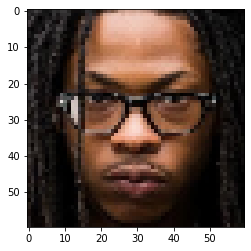

In [5]:
plt.imshow(scaled_faces[2])

### Train the model

In [6]:
use_convo = False
encoding_size = 30

if use_convo:
    enc_input = l = keras.layers.Input(shape=images_shape)
    l = keras.layers.Conv2D(16, (4, 4), activation='relu', padding='same')(l)
    l = keras.layers.MaxPooling2D((3, 3), padding='same')(l)
    l = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(l)
    l = keras.layers.MaxPooling2D((2, 2), padding='same')(l)
    l = keras.layers.Flatten()(l)
    l = keras.layers.Dense(encoding_size, activation='relu')(l)
    encoder = keras.models.Model(inputs=enc_input, outputs=l)

    dec_input = l = keras.layers.Input(shape=(encoding_size,))
    l = keras.layers.Dense(images_shape_flat, activation='relu')(l)
    l = keras.layers.Reshape(target_shape=images_shape)(l)
    l = keras.layers.Conv2D(16, (4, 4), activation='relu', padding='same')(l)
    l = keras.layers.MaxPooling2D((3, 3), padding='same')(l)
    l = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(l)
    l = keras.layers.MaxPooling2D((2, 2), padding='same')(l)
    l = keras.layers.Flatten()(l)
    l = keras.layers.Dense(images_shape_flat, activation='sigmoid')(l)
    l = keras.layers.Reshape(target_shape=images_shape)(l)
    decoder = keras.models.Model(inputs=dec_input, outputs=l)
else:
    enc_input = l = keras.layers.Input(shape=images_shape)
    l = keras.layers.Flatten()(l)
    l = keras.layers.Dense(800, activation='relu')(l)
    l = keras.layers.Dense(encoding_size, activation='relu')(l)
    encoder = keras.models.Model(inputs=enc_input, outputs=l)

    dec_input = l = keras.layers.Input(shape=(encoding_size,))
    l = keras.layers.Dense(800, activation='relu')(l)
    l = keras.layers.Dense(images_shape_flat, activation='sigmoid')(l)
    l = keras.layers.Reshape(target_shape=images_shape)(l)
    decoder = keras.models.Model(inputs=dec_input, outputs=l)

autocoder = keras.models.Model(inputs=enc_input, outputs=decoder(encoder(enc_input)))

autocoder.compile(optimizer='adadelta', loss='mse')

In [7]:
autocoder.fit(
    scaled_faces,
    scaled_faces,
    epochs=3000, 
    batch_size=256,
    shuffle=True
)

Epoch 1/3000
8423/8423 [==============================] - 9s 1ms/step - loss: 0.0707
Epoch 2/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0706
Epoch 3/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0706
Epoch 4/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0704
Epoch 5/3000
8423/8423 [==============================] - 1s 174us/step - loss: 0.0700
Epoch 6/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0692
Epoch 7/3000
8423/8423 [==============================] - 1s 176us/step - loss: 0.0673
Epoch 8/3000
8423/8423 [==============================] - 1s 176us/step - loss: 0.0639
Epoch 9/3000
8423/8423 [==============================] - 2s 194us/step - loss: 0.0595
Epoch 10/3000
8423/8423 [==============================] - 2s 193us/step - loss: 0.0557
Epoch 11/3000
8423/8423 [==============================] - 2s 190us/step - loss: 0.0532
Epoch 12/3000
8423/8423 [==================

8423/8423 [==============================] - 2s 190us/step - loss: 0.0333
Epoch 95/3000
8423/8423 [==============================] - 2s 194us/step - loss: 0.0333
Epoch 96/3000
8423/8423 [==============================] - 2s 187us/step - loss: 0.0331
Epoch 97/3000
8423/8423 [==============================] - 2s 188us/step - loss: 0.0327
Epoch 98/3000
8423/8423 [==============================] - 2s 193us/step - loss: 0.0331
Epoch 99/3000
8423/8423 [==============================] - 2s 191us/step - loss: 0.0331
Epoch 100/3000
8423/8423 [==============================] - 2s 190us/step - loss: 0.0326
Epoch 101/3000
8423/8423 [==============================] - 2s 189us/step - loss: 0.0324
Epoch 102/3000
8423/8423 [==============================] - 2s 189us/step - loss: 0.0325
Epoch 103/3000
8423/8423 [==============================] - 2s 192us/step - loss: 0.0326
Epoch 104/3000
8423/8423 [==============================] - 2s 193us/step - loss: 0.0320
Epoch 105/3000
8423/8423 [===============

8423/8423 [==============================] - 2s 187us/step - loss: 0.0263
Epoch 187/3000
8423/8423 [==============================] - 2s 186us/step - loss: 0.0268
Epoch 188/3000
8423/8423 [==============================] - 2s 186us/step - loss: 0.0265
Epoch 189/3000
8423/8423 [==============================] - 2s 189us/step - loss: 0.0265
Epoch 190/3000
8423/8423 [==============================] - 2s 185us/step - loss: 0.0267
Epoch 191/3000
8423/8423 [==============================] - 2s 186us/step - loss: 0.0262
Epoch 192/3000
8423/8423 [==============================] - 2s 189us/step - loss: 0.0262
Epoch 193/3000
8423/8423 [==============================] - 2s 189us/step - loss: 0.0262
Epoch 194/3000
8423/8423 [==============================] - 2s 189us/step - loss: 0.0262
Epoch 195/3000
8423/8423 [==============================] - 2s 190us/step - loss: 0.0266
Epoch 196/3000
8423/8423 [==============================] - 2s 190us/step - loss: 0.0263
Epoch 197/3000
8423/8423 [==========

8423/8423 [==============================] - 2s 195us/step - loss: 0.0233
Epoch 279/3000
8423/8423 [==============================] - 2s 196us/step - loss: 0.0239
Epoch 280/3000
8423/8423 [==============================] - 2s 192us/step - loss: 0.0235
Epoch 281/3000
8423/8423 [==============================] - 2s 193us/step - loss: 0.0235
Epoch 282/3000
8423/8423 [==============================] - 2s 196us/step - loss: 0.0237
Epoch 283/3000
8423/8423 [==============================] - 2s 199us/step - loss: 0.0233
Epoch 284/3000
8423/8423 [==============================] - 2s 200us/step - loss: 0.0237
Epoch 285/3000
8423/8423 [==============================] - 2s 193us/step - loss: 0.0234
Epoch 286/3000
8423/8423 [==============================] - 2s 196us/step - loss: 0.0235
Epoch 287/3000
8423/8423 [==============================] - 2s 195us/step - loss: 0.0235
Epoch 288/3000
8423/8423 [==============================] - 2s 196us/step - loss: 0.0236
Epoch 289/3000
8423/8423 [==========

8423/8423 [==============================] - 2s 180us/step - loss: 0.0219
Epoch 371/3000
8423/8423 [==============================] - 1s 176us/step - loss: 0.0220
Epoch 372/3000
8423/8423 [==============================] - 1s 174us/step - loss: 0.0218
Epoch 373/3000
8423/8423 [==============================] - 1s 178us/step - loss: 0.0218
Epoch 374/3000
8423/8423 [==============================] - 1s 176us/step - loss: 0.0215
Epoch 375/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0220
Epoch 376/3000
8423/8423 [==============================] - 2s 179us/step - loss: 0.0218
Epoch 377/3000
8423/8423 [==============================] - 1s 174us/step - loss: 0.0217
Epoch 378/3000
8423/8423 [==============================] - 1s 168us/step - loss: 0.0217
Epoch 379/3000
8423/8423 [==============================] - 1s 176us/step - loss: 0.0217
Epoch 380/3000
8423/8423 [==============================] - 1s 178us/step - loss: 0.0216
Epoch 381/3000
8423/8423 [==========

8423/8423 [==============================] - 2s 188us/step - loss: 0.0205
Epoch 463/3000
8423/8423 [==============================] - 2s 184us/step - loss: 0.0201
Epoch 464/3000
8423/8423 [==============================] - 2s 185us/step - loss: 0.0205
Epoch 465/3000
8423/8423 [==============================] - 2s 187us/step - loss: 0.0203
Epoch 466/3000
8423/8423 [==============================] - 2s 187us/step - loss: 0.0203
Epoch 467/3000
8423/8423 [==============================] - 2s 189us/step - loss: 0.0206
Epoch 468/3000
8423/8423 [==============================] - 2s 184us/step - loss: 0.0203
Epoch 469/3000
8423/8423 [==============================] - 2s 183us/step - loss: 0.0202
Epoch 470/3000
8423/8423 [==============================] - 2s 183us/step - loss: 0.0204
Epoch 471/3000
8423/8423 [==============================] - 2s 187us/step - loss: 0.0200
Epoch 472/3000
8423/8423 [==============================] - 2s 190us/step - loss: 0.0202
Epoch 473/3000
8423/8423 [==========

8423/8423 [==============================] - 2s 189us/step - loss: 0.0190
Epoch 555/3000
8423/8423 [==============================] - 2s 188us/step - loss: 0.0195
Epoch 556/3000
8423/8423 [==============================] - 2s 188us/step - loss: 0.0192
Epoch 557/3000
8423/8423 [==============================] - 2s 191us/step - loss: 0.0195
Epoch 558/3000
8423/8423 [==============================] - 2s 190us/step - loss: 0.0194
Epoch 559/3000
8423/8423 [==============================] - 2s 187us/step - loss: 0.0193
Epoch 560/3000
8423/8423 [==============================] - 2s 188us/step - loss: 0.0189
Epoch 561/3000
8423/8423 [==============================] - 2s 182us/step - loss: 0.0192
Epoch 562/3000
8423/8423 [==============================] - 2s 180us/step - loss: 0.0193
Epoch 563/3000
8423/8423 [==============================] - 2s 182us/step - loss: 0.0193
Epoch 564/3000
8423/8423 [==============================] - 2s 187us/step - loss: 0.0190
Epoch 565/3000
8423/8423 [==========

8423/8423 [==============================] - 1s 175us/step - loss: 0.0183
Epoch 647/3000
8423/8423 [==============================] - 1s 176us/step - loss: 0.0183
Epoch 648/3000
8423/8423 [==============================] - 2s 180us/step - loss: 0.0185
Epoch 649/3000
8423/8423 [==============================] - 1s 175us/step - loss: 0.0183
Epoch 650/3000
8423/8423 [==============================] - 1s 177us/step - loss: 0.0187
Epoch 651/3000
8423/8423 [==============================] - 2s 182us/step - loss: 0.0183
Epoch 652/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0186
Epoch 653/3000
8423/8423 [==============================] - 1s 174us/step - loss: 0.0185
Epoch 654/3000
8423/8423 [==============================] - 1s 178us/step - loss: 0.0183
Epoch 655/3000
8423/8423 [==============================] - 2s 181us/step - loss: 0.0184
Epoch 656/3000
8423/8423 [==============================] - 1s 176us/step - loss: 0.0181
Epoch 657/3000
8423/8423 [==========

8423/8423 [==============================] - 1s 168us/step - loss: 0.0179
Epoch 739/3000
8423/8423 [==============================] - 1s 167us/step - loss: 0.0177
Epoch 740/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0179
Epoch 741/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0177
Epoch 742/3000
8423/8423 [==============================] - 1s 166us/step - loss: 0.0180
Epoch 743/3000
8423/8423 [==============================] - 1s 168us/step - loss: 0.0178
Epoch 744/3000
8423/8423 [==============================] - 1s 167us/step - loss: 0.0176
Epoch 745/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0179
Epoch 746/3000
8423/8423 [==============================] - 1s 174us/step - loss: 0.0177
Epoch 747/3000
8423/8423 [==============================] - 1s 167us/step - loss: 0.0178
Epoch 748/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0179
Epoch 749/3000
8423/8423 [==========

8423/8423 [==============================] - 1s 171us/step - loss: 0.0174
Epoch 831/3000
8423/8423 [==============================] - 1s 177us/step - loss: 0.0172
Epoch 832/3000
8423/8423 [==============================] - 2s 178us/step - loss: 0.0172
Epoch 833/3000
8423/8423 [==============================] - 2s 179us/step - loss: 0.0174
Epoch 834/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0171
Epoch 835/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0173
Epoch 836/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0173
Epoch 837/3000
8423/8423 [==============================] - 1s 167us/step - loss: 0.0173
Epoch 838/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0173
Epoch 839/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0173
Epoch 840/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0174
Epoch 841/3000
8423/8423 [==========

8423/8423 [==============================] - 1s 176us/step - loss: 0.0167
Epoch 923/3000
8423/8423 [==============================] - 1s 174us/step - loss: 0.0169
Epoch 924/3000
8423/8423 [==============================] - 1s 174us/step - loss: 0.0171
Epoch 925/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0169
Epoch 926/3000
8423/8423 [==============================] - 1s 167us/step - loss: 0.0169
Epoch 927/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0169
Epoch 928/3000
8423/8423 [==============================] - 1s 174us/step - loss: 0.0169
Epoch 929/3000
8423/8423 [==============================] - 1s 177us/step - loss: 0.0169
Epoch 930/3000
8423/8423 [==============================] - 1s 174us/step - loss: 0.0170
Epoch 931/3000
8423/8423 [==============================] - 1s 176us/step - loss: 0.0167
Epoch 932/3000
8423/8423 [==============================] - 1s 174us/step - loss: 0.0168
Epoch 933/3000
8423/8423 [==========

8423/8423 [==============================] - 1s 168us/step - loss: 0.0166
Epoch 1015/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0165
Epoch 1016/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0165
Epoch 1017/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0165
Epoch 1018/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0166
Epoch 1019/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0165
Epoch 1020/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0165
Epoch 1021/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0164
Epoch 1022/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0166
Epoch 1023/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0163
Epoch 1024/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0164
Epoch 1025/3000
8423/8423 

8423/8423 [==============================] - 1s 175us/step - loss: 0.0163
Epoch 1106/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0161
Epoch 1107/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0162
Epoch 1108/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0162
Epoch 1109/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0161
Epoch 1110/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0163
Epoch 1111/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0162
Epoch 1112/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0161
Epoch 1113/3000
8423/8423 [==============================] - 1s 175us/step - loss: 0.0162
Epoch 1114/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0163
Epoch 1115/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0162
Epoch 1116/3000
8423/8423 

8423/8423 [==============================] - 1s 175us/step - loss: 0.0160
Epoch 1197/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0157
Epoch 1198/3000
8423/8423 [==============================] - 1s 176us/step - loss: 0.0158
Epoch 1199/3000
8423/8423 [==============================] - 2s 184us/step - loss: 0.0160
Epoch 1200/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0159
Epoch 1201/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0160
Epoch 1202/3000
8423/8423 [==============================] - 1s 167us/step - loss: 0.0159
Epoch 1203/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0159
Epoch 1204/3000
8423/8423 [==============================] - 2s 180us/step - loss: 0.0159
Epoch 1205/3000
8423/8423 [==============================] - 2s 180us/step - loss: 0.0160
Epoch 1206/3000
8423/8423 [==============================] - 1s 177us/step - loss: 0.0159
Epoch 1207/3000
8423/8423 

8423/8423 [==============================] - 1s 170us/step - loss: 0.0156
Epoch 1288/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0156
Epoch 1289/3000
8423/8423 [==============================] - 1s 167us/step - loss: 0.0156
Epoch 1290/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0156
Epoch 1291/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0155
Epoch 1292/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0156
Epoch 1293/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0157
Epoch 1294/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0156
Epoch 1295/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0157
Epoch 1296/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0155
Epoch 1297/3000
8423/8423 [==============================] - 1s 165us/step - loss: 0.0157
Epoch 1298/3000
8423/8423 

8423/8423 [==============================] - 1s 168us/step - loss: 0.0153
Epoch 1379/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0153
Epoch 1380/3000
8423/8423 [==============================] - 1s 167us/step - loss: 0.0155
Epoch 1381/3000
8423/8423 [==============================] - 1s 165us/step - loss: 0.0154
Epoch 1382/3000
8423/8423 [==============================] - 1s 165us/step - loss: 0.0154
Epoch 1383/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0154
Epoch 1384/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0153
Epoch 1385/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0155
Epoch 1386/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0154
Epoch 1387/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0152
Epoch 1388/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0155
Epoch 1389/3000
8423/8423 

8423/8423 [==============================] - 1s 171us/step - loss: 0.0152
Epoch 1470/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0152
Epoch 1471/3000
8423/8423 [==============================] - 1s 166us/step - loss: 0.0153
Epoch 1472/3000
8423/8423 [==============================] - 1s 165us/step - loss: 0.0151
Epoch 1473/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0152
Epoch 1474/3000
8423/8423 [==============================] - 1s 165us/step - loss: 0.0152
Epoch 1475/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0153
Epoch 1476/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0151
Epoch 1477/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0152
Epoch 1478/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0152
Epoch 1479/3000
8423/8423 [==============================] - 1s 177us/step - loss: 0.0153
Epoch 1480/3000
8423/8423 

8423/8423 [==============================] - 1s 174us/step - loss: 0.0151
Epoch 1561/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0150
Epoch 1562/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0151
Epoch 1563/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0152
Epoch 1564/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0150
Epoch 1565/3000
8423/8423 [==============================] - 1s 167us/step - loss: 0.0151
Epoch 1566/3000
8423/8423 [==============================] - 1s 167us/step - loss: 0.0147
Epoch 1567/3000
8423/8423 [==============================] - 1s 176us/step - loss: 0.0152
Epoch 1568/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0151
Epoch 1569/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0151
Epoch 1570/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0149
Epoch 1571/3000
8423/8423 

8423/8423 [==============================] - 1s 164us/step - loss: 0.0148
Epoch 1652/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0150
Epoch 1653/3000
8423/8423 [==============================] - 1s 168us/step - loss: 0.0149
Epoch 1654/3000
8423/8423 [==============================] - 1s 167us/step - loss: 0.0150
Epoch 1655/3000
8423/8423 [==============================] - 1s 168us/step - loss: 0.0149
Epoch 1656/3000
8423/8423 [==============================] - 1s 168us/step - loss: 0.0149
Epoch 1657/3000
8423/8423 [==============================] - 1s 168us/step - loss: 0.0149
Epoch 1658/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0149
Epoch 1659/3000
8423/8423 [==============================] - 1s 166us/step - loss: 0.0149
Epoch 1660/3000
8423/8423 [==============================] - 1s 165us/step - loss: 0.0150
Epoch 1661/3000
8423/8423 [==============================] - 1s 167us/step - loss: 0.0148
Epoch 1662/3000
8423/8423 

8423/8423 [==============================] - 1s 176us/step - loss: 0.0149
Epoch 1743/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0149
Epoch 1744/3000
8423/8423 [==============================] - 1s 175us/step - loss: 0.0147
Epoch 1745/3000
8423/8423 [==============================] - 2s 178us/step - loss: 0.0148
Epoch 1746/3000
8423/8423 [==============================] - 1s 176us/step - loss: 0.0149
Epoch 1747/3000
8423/8423 [==============================] - 1s 176us/step - loss: 0.0148
Epoch 1748/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0148
Epoch 1749/3000
8423/8423 [==============================] - 1s 176us/step - loss: 0.0148
Epoch 1750/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0147
Epoch 1751/3000
8423/8423 [==============================] - 1s 176us/step - loss: 0.0148
Epoch 1752/3000
8423/8423 [==============================] - 2s 178us/step - loss: 0.0148
Epoch 1753/3000
8423/8423 

8423/8423 [==============================] - 2s 181us/step - loss: 0.0147
Epoch 1834/3000
8423/8423 [==============================] - 1s 178us/step - loss: 0.0146
Epoch 1835/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0147
Epoch 1836/3000
8423/8423 [==============================] - 1s 177us/step - loss: 0.0147
Epoch 1837/3000
8423/8423 [==============================] - 2s 179us/step - loss: 0.0147
Epoch 1838/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0148
Epoch 1839/3000
8423/8423 [==============================] - 1s 177us/step - loss: 0.0147
Epoch 1840/3000
8423/8423 [==============================] - 1s 177us/step - loss: 0.0147
Epoch 1841/3000
8423/8423 [==============================] - 1s 178us/step - loss: 0.0146
Epoch 1842/3000
8423/8423 [==============================] - 1s 176us/step - loss: 0.0147
Epoch 1843/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0146
Epoch 1844/3000
8423/8423 

8423/8423 [==============================] - 1s 171us/step - loss: 0.0146
Epoch 1925/3000
8423/8423 [==============================] - 1s 175us/step - loss: 0.0147
Epoch 1926/3000
8423/8423 [==============================] - 1s 174us/step - loss: 0.0145
Epoch 1927/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0147
Epoch 1928/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0146
Epoch 1929/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0147
Epoch 1930/3000
8423/8423 [==============================] - 1s 175us/step - loss: 0.0147
Epoch 1931/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0146
Epoch 1932/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0147
Epoch 1933/3000
8423/8423 [==============================] - 1s 174us/step - loss: 0.0146
Epoch 1934/3000
8423/8423 [==============================] - 1s 176us/step - loss: 0.0145
Epoch 1935/3000
8423/8423 

8423/8423 [==============================] - 1s 175us/step - loss: 0.0145
Epoch 2016/3000
8423/8423 [==============================] - 1s 177us/step - loss: 0.0146
Epoch 2017/3000
8423/8423 [==============================] - 1s 177us/step - loss: 0.0146
Epoch 2018/3000
8423/8423 [==============================] - 2s 180us/step - loss: 0.0145
Epoch 2019/3000
8423/8423 [==============================] - 1s 175us/step - loss: 0.0146
Epoch 2020/3000
8423/8423 [==============================] - 1s 175us/step - loss: 0.0146
Epoch 2021/3000
8423/8423 [==============================] - 2s 178us/step - loss: 0.0146
Epoch 2022/3000
8423/8423 [==============================] - 1s 178us/step - loss: 0.0145
Epoch 2023/3000
8423/8423 [==============================] - 1s 175us/step - loss: 0.0146
Epoch 2024/3000
8423/8423 [==============================] - 1s 176us/step - loss: 0.0145
Epoch 2025/3000
8423/8423 [==============================] - 2s 181us/step - loss: 0.0145
Epoch 2026/3000
8423/8423 

8423/8423 [==============================] - 1s 173us/step - loss: 0.0144
Epoch 2107/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0144
Epoch 2108/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0145
Epoch 2109/3000
8423/8423 [==============================] - 1s 178us/step - loss: 0.0145
Epoch 2110/3000
8423/8423 [==============================] - 2s 182us/step - loss: 0.0144
Epoch 2111/3000
8423/8423 [==============================] - 2s 178us/step - loss: 0.0145
Epoch 2112/3000
8423/8423 [==============================] - 2s 178us/step - loss: 0.0145
Epoch 2113/3000
8423/8423 [==============================] - 1s 177us/step - loss: 0.0145
Epoch 2114/3000
8423/8423 [==============================] - 1s 175us/step - loss: 0.0145
Epoch 2115/3000
8423/8423 [==============================] - 2s 182us/step - loss: 0.0145
Epoch 2116/3000
8423/8423 [==============================] - 2s 184us/step - loss: 0.0145
Epoch 2117/3000
8423/8423 

8423/8423 [==============================] - 1s 170us/step - loss: 0.0145
Epoch 2198/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0144
Epoch 2199/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0146
Epoch 2200/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0145
Epoch 2201/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0145
Epoch 2202/3000
8423/8423 [==============================] - 1s 174us/step - loss: 0.0144
Epoch 2203/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0145
Epoch 2204/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0145
Epoch 2205/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0144
Epoch 2206/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0145
Epoch 2207/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0145
Epoch 2208/3000
8423/8423 

8423/8423 [==============================] - 1s 169us/step - loss: 0.0145
Epoch 2289/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0144
Epoch 2290/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0145
Epoch 2291/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0144
Epoch 2292/3000
8423/8423 [==============================] - 1s 167us/step - loss: 0.0145
Epoch 2293/3000
8423/8423 [==============================] - 1s 168us/step - loss: 0.0145
Epoch 2294/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0145
Epoch 2295/3000
8423/8423 [==============================] - 1s 166us/step - loss: 0.0144
Epoch 2296/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0145
Epoch 2297/3000
8423/8423 [==============================] - 1s 167us/step - loss: 0.0145
Epoch 2298/3000
8423/8423 [==============================] - 1s 168us/step - loss: 0.0144
Epoch 2299/3000
8423/8423 

8423/8423 [==============================] - 1s 170us/step - loss: 0.0144
Epoch 2380/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0144
Epoch 2381/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0144
Epoch 2382/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0144
Epoch 2383/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0145
Epoch 2384/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0143
Epoch 2385/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0143
Epoch 2386/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0144
Epoch 2387/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0144
Epoch 2388/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0143
Epoch 2389/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0144
Epoch 2390/3000
8423/8423 

8423/8423 [==============================] - 1s 173us/step - loss: 0.0144
Epoch 2471/3000
8423/8423 [==============================] - 1s 174us/step - loss: 0.0144
Epoch 2472/3000
8423/8423 [==============================] - 1s 167us/step - loss: 0.0144
Epoch 2473/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0143
Epoch 2474/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0144
Epoch 2475/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0144
Epoch 2476/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0143
Epoch 2477/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0145
Epoch 2478/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0143
Epoch 2479/3000
8423/8423 [==============================] - 1s 174us/step - loss: 0.0144
Epoch 2480/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0143
Epoch 2481/3000
8423/8423 

8423/8423 [==============================] - 1s 170us/step - loss: 0.0144
Epoch 2562/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0144
Epoch 2563/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0142
Epoch 2564/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0143
Epoch 2565/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0144
Epoch 2566/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0143
Epoch 2567/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0144
Epoch 2568/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0144
Epoch 2569/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0144
Epoch 2570/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0142
Epoch 2571/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0144
Epoch 2572/3000
8423/8423 

8423/8423 [==============================] - 1s 172us/step - loss: 0.0143
Epoch 2653/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0144
Epoch 2654/3000
8423/8423 [==============================] - 1s 175us/step - loss: 0.0144
Epoch 2655/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0143
Epoch 2656/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0143
Epoch 2657/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0143
Epoch 2658/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0143
Epoch 2659/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0144
Epoch 2660/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0143
Epoch 2661/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0143
Epoch 2662/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0143
Epoch 2663/3000
8423/8423 

8423/8423 [==============================] - 1s 168us/step - loss: 0.0143
Epoch 2744/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0143
Epoch 2745/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0143
Epoch 2746/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0143
Epoch 2747/3000
8423/8423 [==============================] - 1s 167us/step - loss: 0.0142
Epoch 2748/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0143
Epoch 2749/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0142
Epoch 2750/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0143
Epoch 2751/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0143
Epoch 2752/3000
8423/8423 [==============================] - 1s 168us/step - loss: 0.0143
Epoch 2753/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0142
Epoch 2754/3000
8423/8423 

8423/8423 [==============================] - 1s 169us/step - loss: 0.0143
Epoch 2835/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0143
Epoch 2836/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0143
Epoch 2837/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0143
Epoch 2838/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0141
Epoch 2839/3000
8423/8423 [==============================] - 1s 170us/step - loss: 0.0143
Epoch 2840/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0142
Epoch 2841/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0144
Epoch 2842/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0143
Epoch 2843/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0143
Epoch 2844/3000
8423/8423 [==============================] - 1s 171us/step - loss: 0.0143
Epoch 2845/3000
8423/8423 

8423/8423 [==============================] - 1s 169us/step - loss: 0.0143
Epoch 2926/3000
8423/8423 [==============================] - 1s 174us/step - loss: 0.0143
Epoch 2927/3000
8423/8423 [==============================] - 1s 174us/step - loss: 0.0142
Epoch 2928/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0143
Epoch 2929/3000
8423/8423 [==============================] - 1s 168us/step - loss: 0.0142
Epoch 2930/3000
8423/8423 [==============================] - 1s 174us/step - loss: 0.0142
Epoch 2931/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0143
Epoch 2932/3000
8423/8423 [==============================] - 1s 169us/step - loss: 0.0142
Epoch 2933/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0143
Epoch 2934/3000
8423/8423 [==============================] - 1s 173us/step - loss: 0.0143
Epoch 2935/3000
8423/8423 [==============================] - 1s 172us/step - loss: 0.0142
Epoch 2936/3000
8423/8423 

In [8]:
if use_convo:
    enc_name = 'data/convo_encoder60.keras'
    dec_name = 'data/convo_decoder60.keras'
else:
    enc_name = 'data/deep_encoder60.keras'
    dec_name = 'data/deep_decoder60.keras'

encoder.save(enc_name)
decoder.save(dec_name)
encoder = keras.models.load_model(enc_name)
decoder = keras.models.load_model(dec_name)

/home/wurst/.local/lib/python3.7/site-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


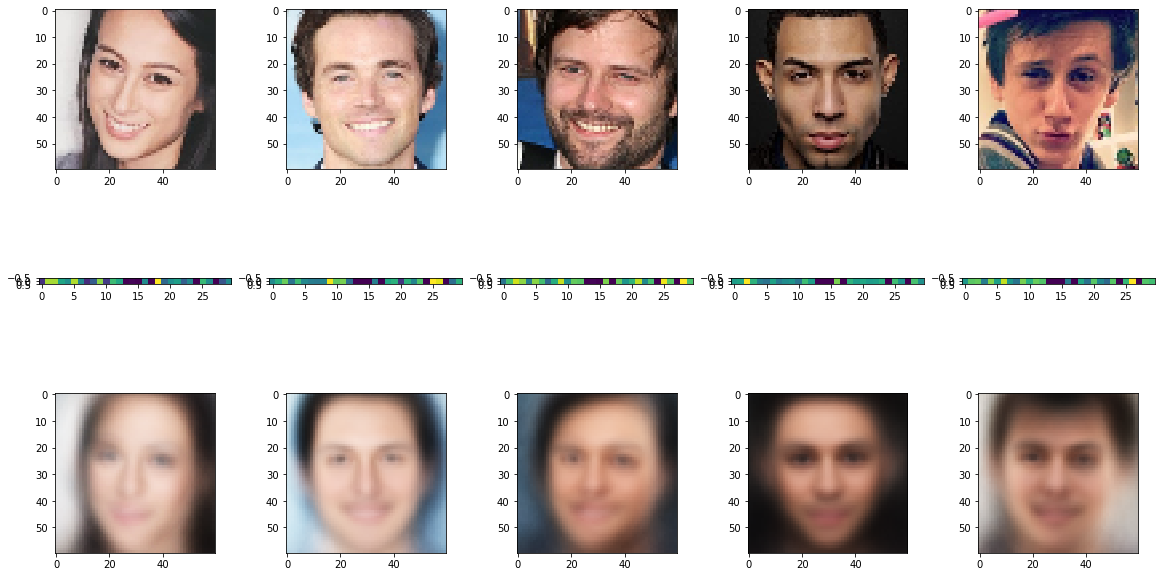

In [10]:
plt.figure(figsize=(20, 10))

n = 5

for i, img in enumerate(scaled_faces[np.random.randint(len(scaled_faces), size=n), :, :, :]):
    encoded = encoder.predict(img.reshape(1, *images_shape))[0]
    decoded = decoder.predict(encoded.reshape(1, -1))[0]
    
    plt.subplot(3, n, i+1)
    plt.imshow(img)
    
    plt.subplot(3, n, i+n+1)
    plt.imshow(encoded.reshape(1, -1))

    plt.subplot(3, n, i+n+n+1)
    plt.imshow(decoded)